# Advanced Lane Lines Detection

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math

%matplotlib inline

In [2]:
### Utility Functions

def tryint(s):
    try:
        return int(s)
    except:
        return s
     
def alphanum_key(s):
    ''' 
    Turn a string into a list of string and number chunks.
    E.g. "z23a" -> ["z", 23, "a"]
    '''
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(l):
    ''' 
    Sort the given list in the way that humans expect.
    '''
    l.sort(key=alphanum_key)
    
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

def capture_frames(video_path, frames_dir):
    '''
    Utility function that captures and stores video frames
    :param video_path (string): Video path
    :param frames_dir (string): Frames directory
    '''
    cap = cv2.VideoCapture(video_path)

    print('Starting frame capture...')
    
    count = 0
    success = True
    while success:
        success, frame = cap.read()
        cv2.imwrite(frames_dir + 'frame{:02}.jpg'.format(count), frame)
        count += 1

    print('Completed!')
    

test_img_paths = glob.glob('test_images/test*.jpg')
sort_nicely(test_img_paths)

video1 = glob.glob('video_frames/frame*.jpg')
sort_nicely(video1)

video2 = glob.glob('video_frames_1/frame*.jpg')
sort_nicely(video2)

# List of all demos to visualise
plot_demo = [1, 2, 3, 4, 5, 6, 7, 8]

## 1. Camera Calibration & Distortion correction

Compute the camera calibration matrix and distortion coefficients

In [3]:
def calibrate_camera():
    '''
    Computes the camera calibration matrix and distortion coefficients
    :return: Camera calibration matrix and distortion coefficients
    '''
    
    imgpaths = glob.glob('camera_cal/calibration*.jpg')
    sort_nicely(img_paths)
    
    # View a sample calibration image
    %matplotlib inline
    
    image = cv2.imread(imgpaths[0])
    imshape = image.shape[:2] # gets only the (height, width) to be used in the cv2.calibrateCamera()
    
    plt.imshow(image)
    plt.show()
    print('Image shape: {}'.format(image.shape))

    %matplotlib qt
    print()
    print('Calibrating the camera...')
    print()

    objpoints = []
    imgpoints = []

    nx = 9 # Number of inside corners on each row of the chessboard
    ny = 6 # Number of inside corners on each column of the chessboard

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros([ny*nx, 3], dtype=np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Iterate over each calibration image and determine the objpoints and imgpoints
    for idx, imgpath in enumerate(imgpaths):
        img = cv2.imread(imgpath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

            imgpoints.append(corners)
            objpoints.append(objp)

            cv2.imshow('img', img)
            cv2.waitKey(500)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[::-1], None, None)
   
    print('Calibration complete!')
    cv2.destroyAllWindows()
    return mtx, dist

# Note: the calibration process only needs to be run once in the absense of the pickled file
# containing the calculated aforementioned params
if os.path.exists('camera_calib.p'):
    with open('camera_calib.p', mode='rb') as f:
        data = pickle.load(f)
        mtx, dist = data['mtx'], data['dist']
        print('Loaded the saved camera calibration matrix & dist coefficients!')
else:
    mtx, dist = calibrate_camera()
    with open('camera_calib.p', mode='wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)

def undistort(img, mtx, dist):
    '''
    Undistorts an image
    :param img (ndarray): Image, represented an a numpy array
    :param mtx: Camera calibration matrix
    :param dist: Distortion coeff's
    :return : Undistorted image
    '''
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

Loaded the saved camera calibration matrix & dist coefficients!


### 1.1 Demo

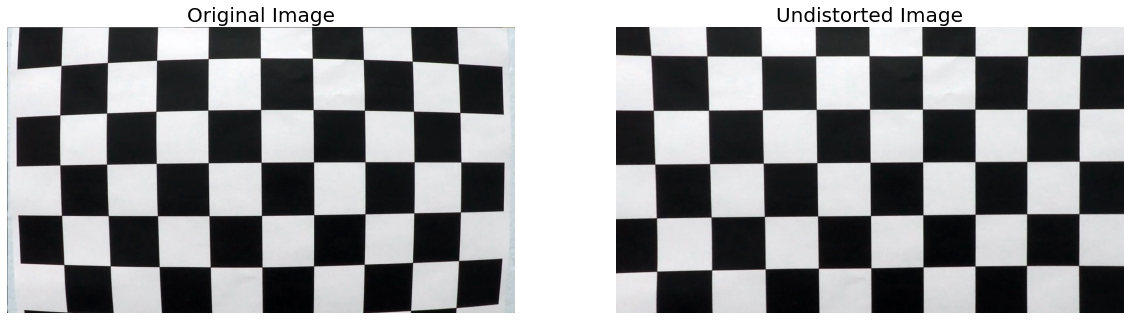

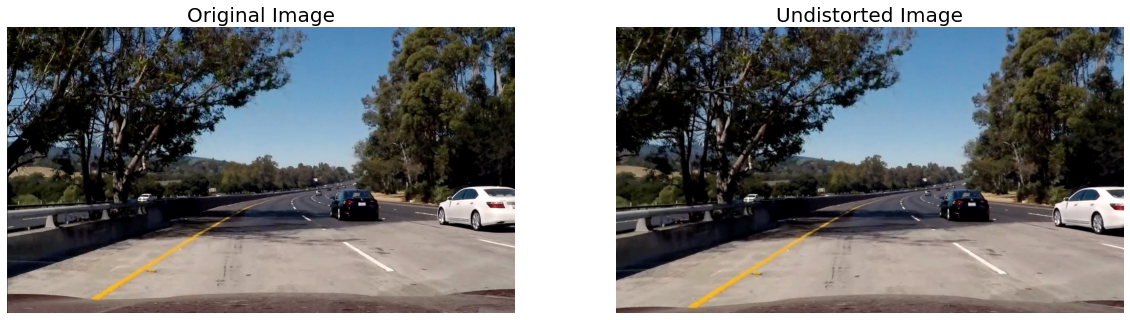

In [4]:
# Undistort a sample camera calibration image and a sample test image

if 1 in plot_demo:
    ccimg = cv2.imread('camera_cal/calibration1.jpg')
    ccimg_undist = undistort(ccimg, mtx, dist)

    plot_images([
        (ccimg, 'Original Image'),
        (ccimg_undist, 'Undistorted Image')
    ])
    
    img_orig = mpimg.imread(test_img_paths[6])
    img = undistort(img_orig, mtx, dist)

    plot_images([
        (img_orig, 'Original Image'),
        (img, 'Undistorted Image')
    ])

## 2. Perspective Transformation

In [5]:
IMG_SHAPE = (720, 1280)

def get_roi(img, vertices):
    '''
    Transforms an image by preserving only the ROI represented by the
    the 'vertices' and removes the remainder of the image by setting the pixel intensity to 0
    :param img (ndarray): Image
    :param vertices (ndarray): Region of Interest of the image
    :return : Modified image
    '''
    
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)
    
def warp_image(img, warp_shape, src, dst):
    '''
    Performs perspective transformation (PT)
    :param img (ndarray): Image
    :param warp_shape: Shape of the warped image
    :param src (ndarray): Source points
    :param dst (ndarray): Destination points
    :return : Tuple (Transformed image, PT matrix, PT inverse matrix)
    '''
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

def preprocess_image(img, visualise=False):
    '''
    Pre-processes an image. Steps include:
    1. Distortion correction
    2. Perspective Transformation
    3. ROI crop
    
    :param img (ndarray): Original Image
    :param visualise (boolean): Boolean flag for visualisation
    :return : Pre-processed image, (PT matrix, PT inverse matrix)
    '''
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # 1. Distortion correction
    undist = undistort(img, mtx, dist)
    
    # 2. Perspective transformation
    src = np.float32([
        (696,455),    
        (587,455), 
        (235,700),  
        (1075,700)
    ])

    dst = np.float32([
        (xsize - 350, 0),
        (350, 0),
        (350, ysize),
        (xsize - 350, ysize)
    ])

    warped, M, invM = warp_image(undist, (xsize, ysize), src, dst)

    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [1100, 0],
        [1100, ysize]
    ])

    roi = get_roi(warped, vertices)

    # 4. Visualise the transformation
    if visualise:
        img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        cv2.polylines(img_copy, [np.int32(src)], True, (255, 0, 0), 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, (255, 0, 0), 3)
        
        plot_images([
            (img_copy, 'Original Image'),
            (roi_copy, 'Bird\'s Eye View Perspective')
        ])

    return roi, (M, invM)

def get_image(img_path, visualise=False):
    '''
    Load an image from the 'img_path' and pre-process it
    :param img_path (string): Image path
    :param visualise (boolean): Boolean flag for visualisation
    :return : Transformed Image, (PT matrix, PT inv matrix)
    '''
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

### 2.1 Demo

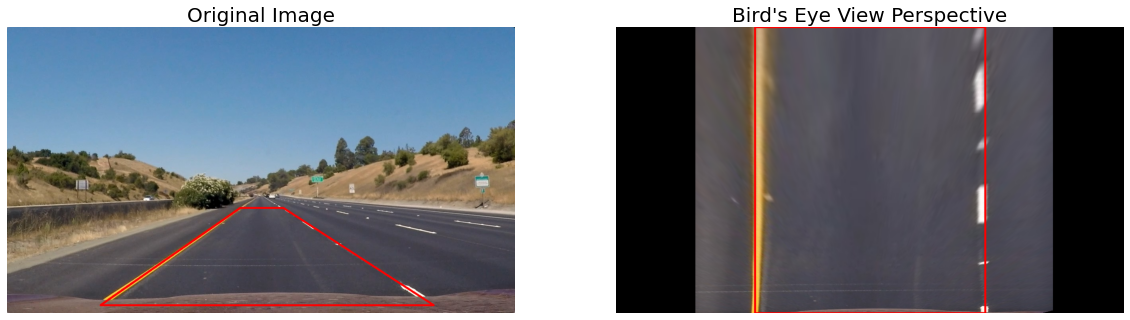

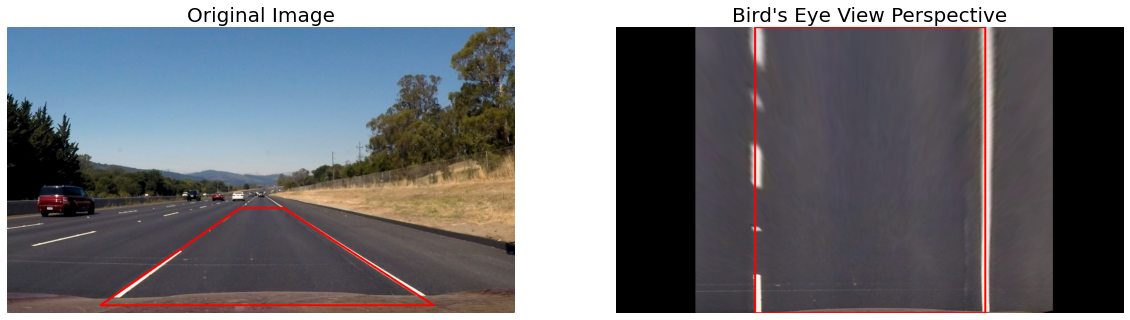

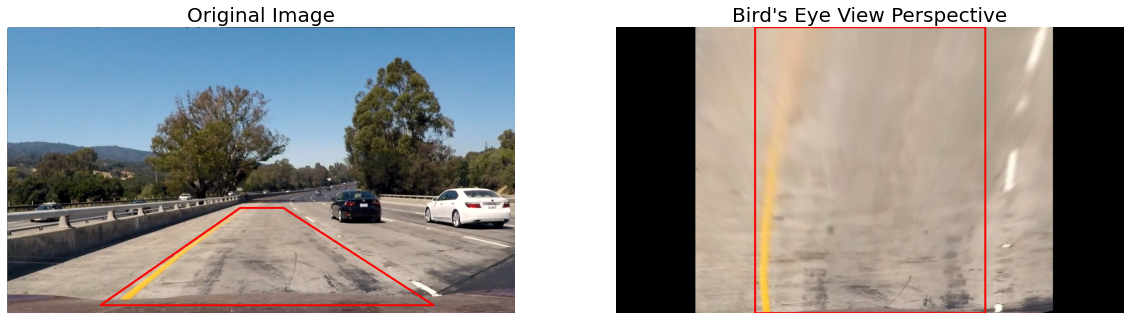

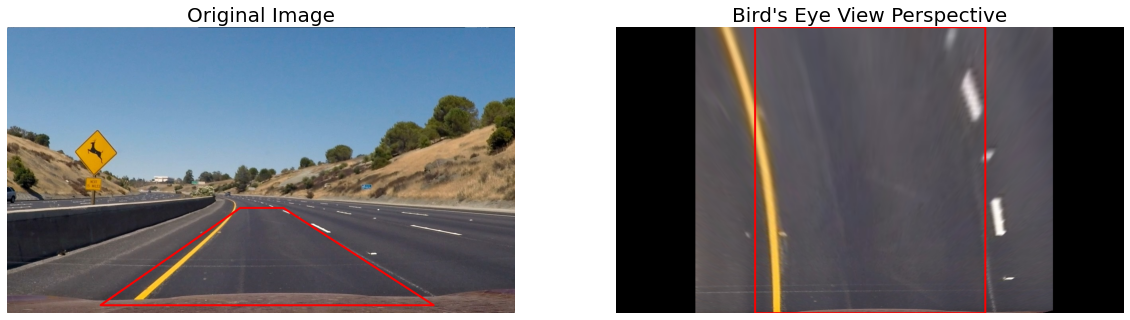

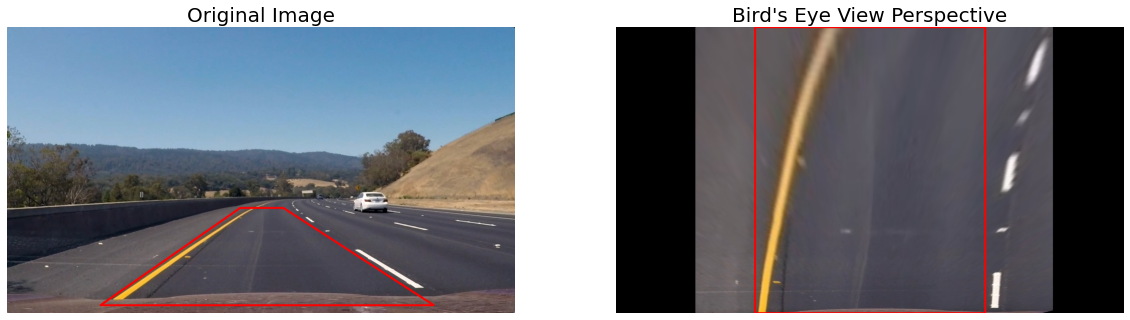

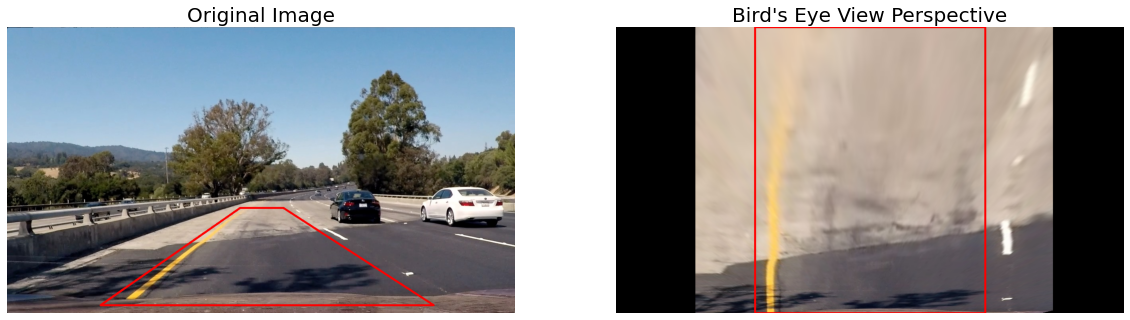

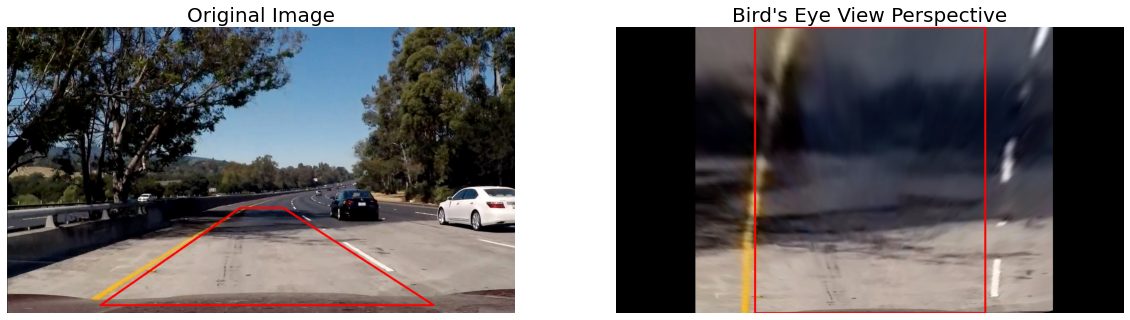

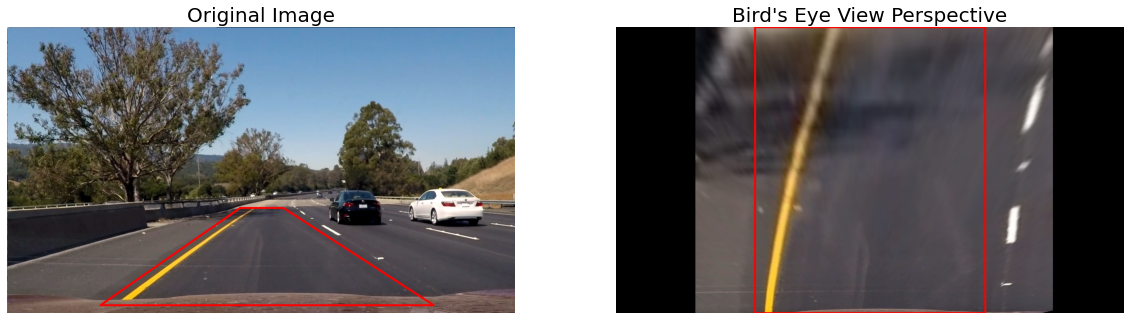

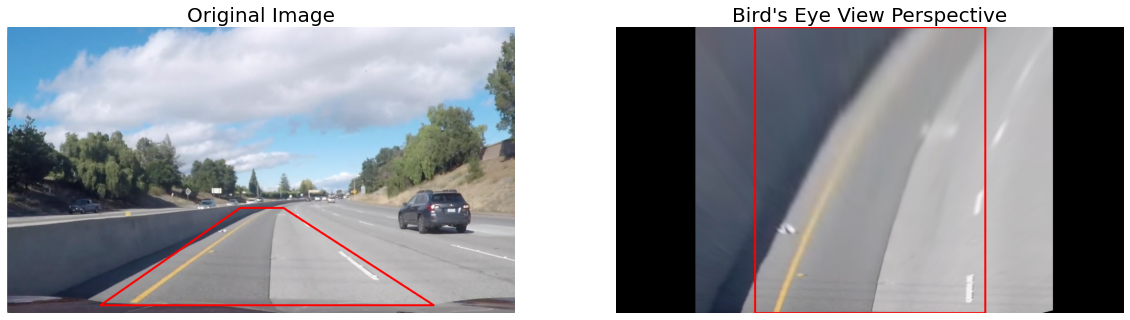

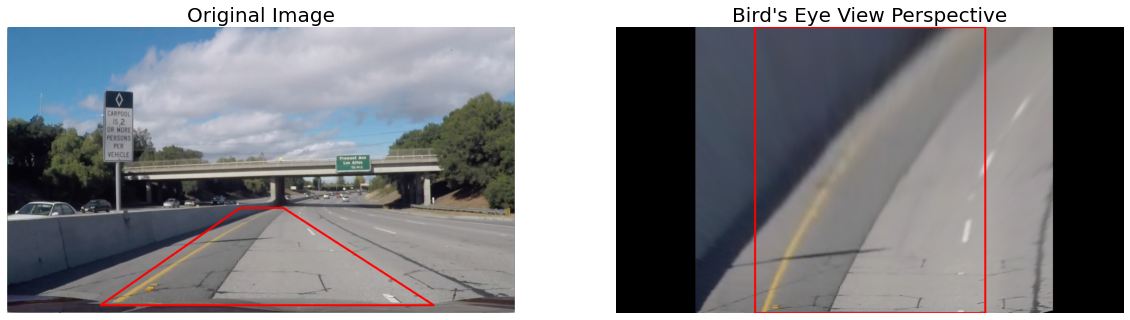

In [6]:
if 2 in plot_demo:
    for path in test_img_paths[:]:
        get_image(path, visualise=True)

## 3. Generate Thresholded Binary image

In [7]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

def get_binary_image(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces: 
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and 
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """
    
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white

    ### Ensemble Voting
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1

    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

### 3.1 Demo

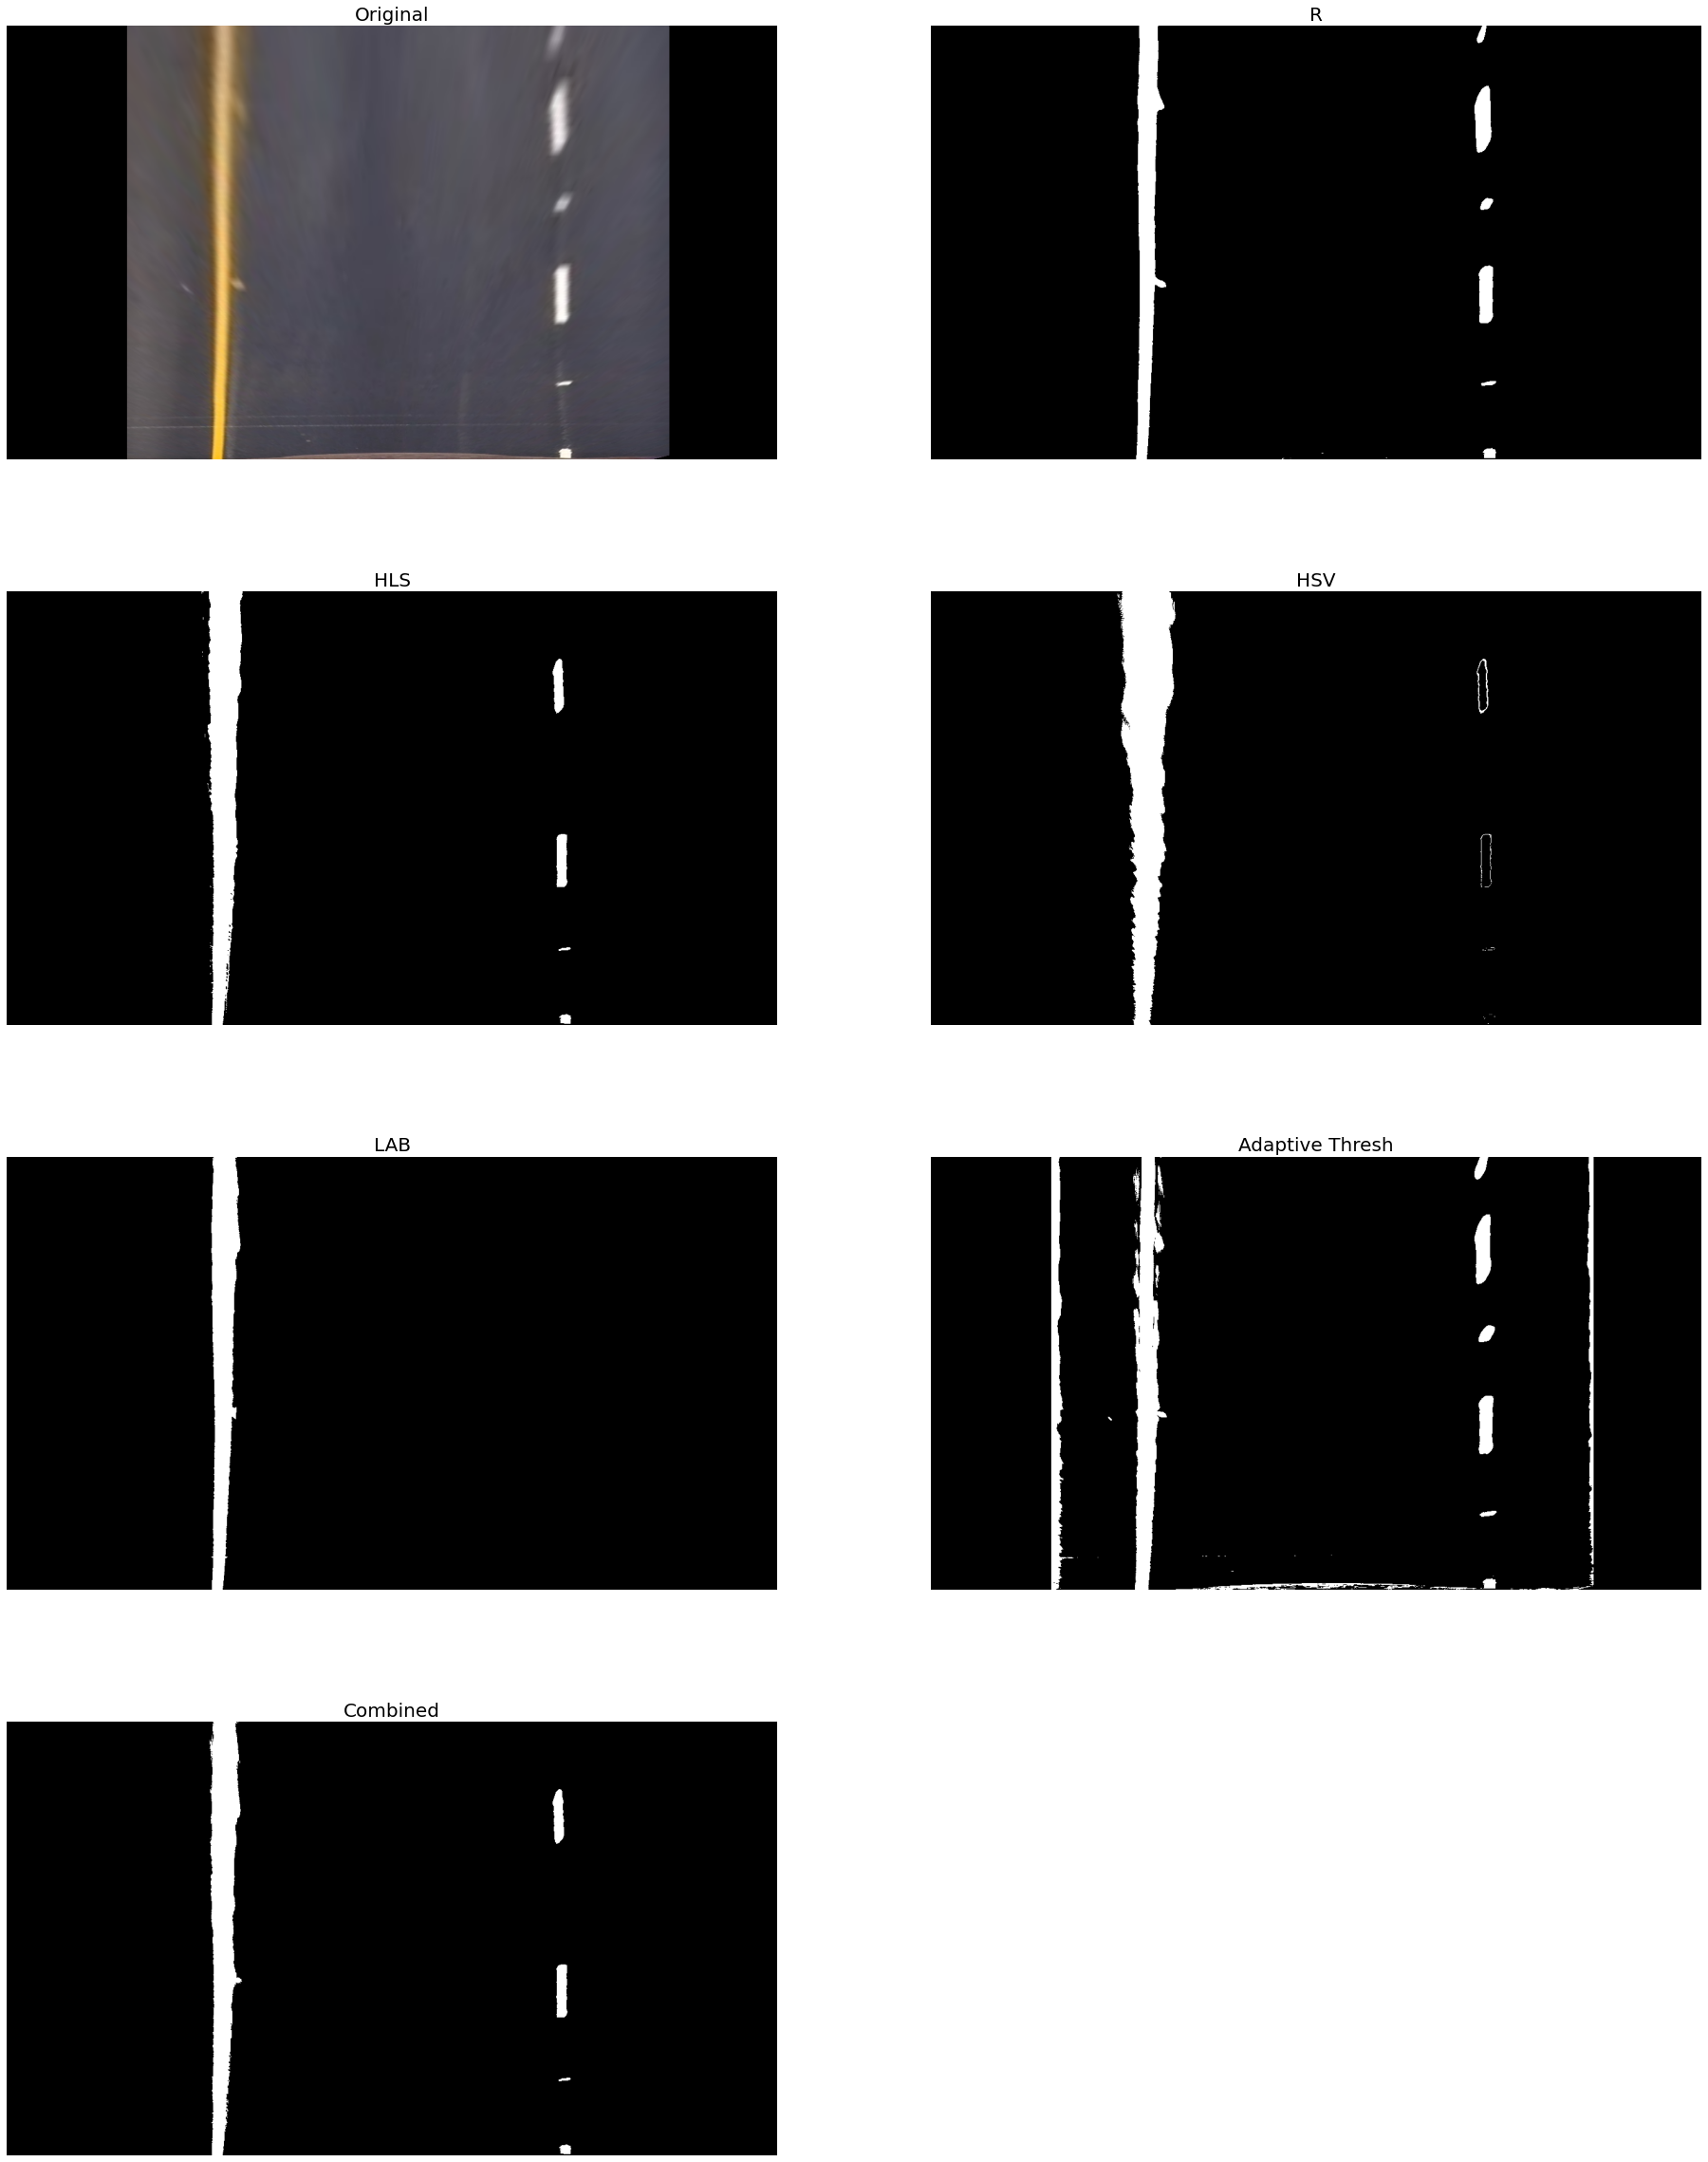

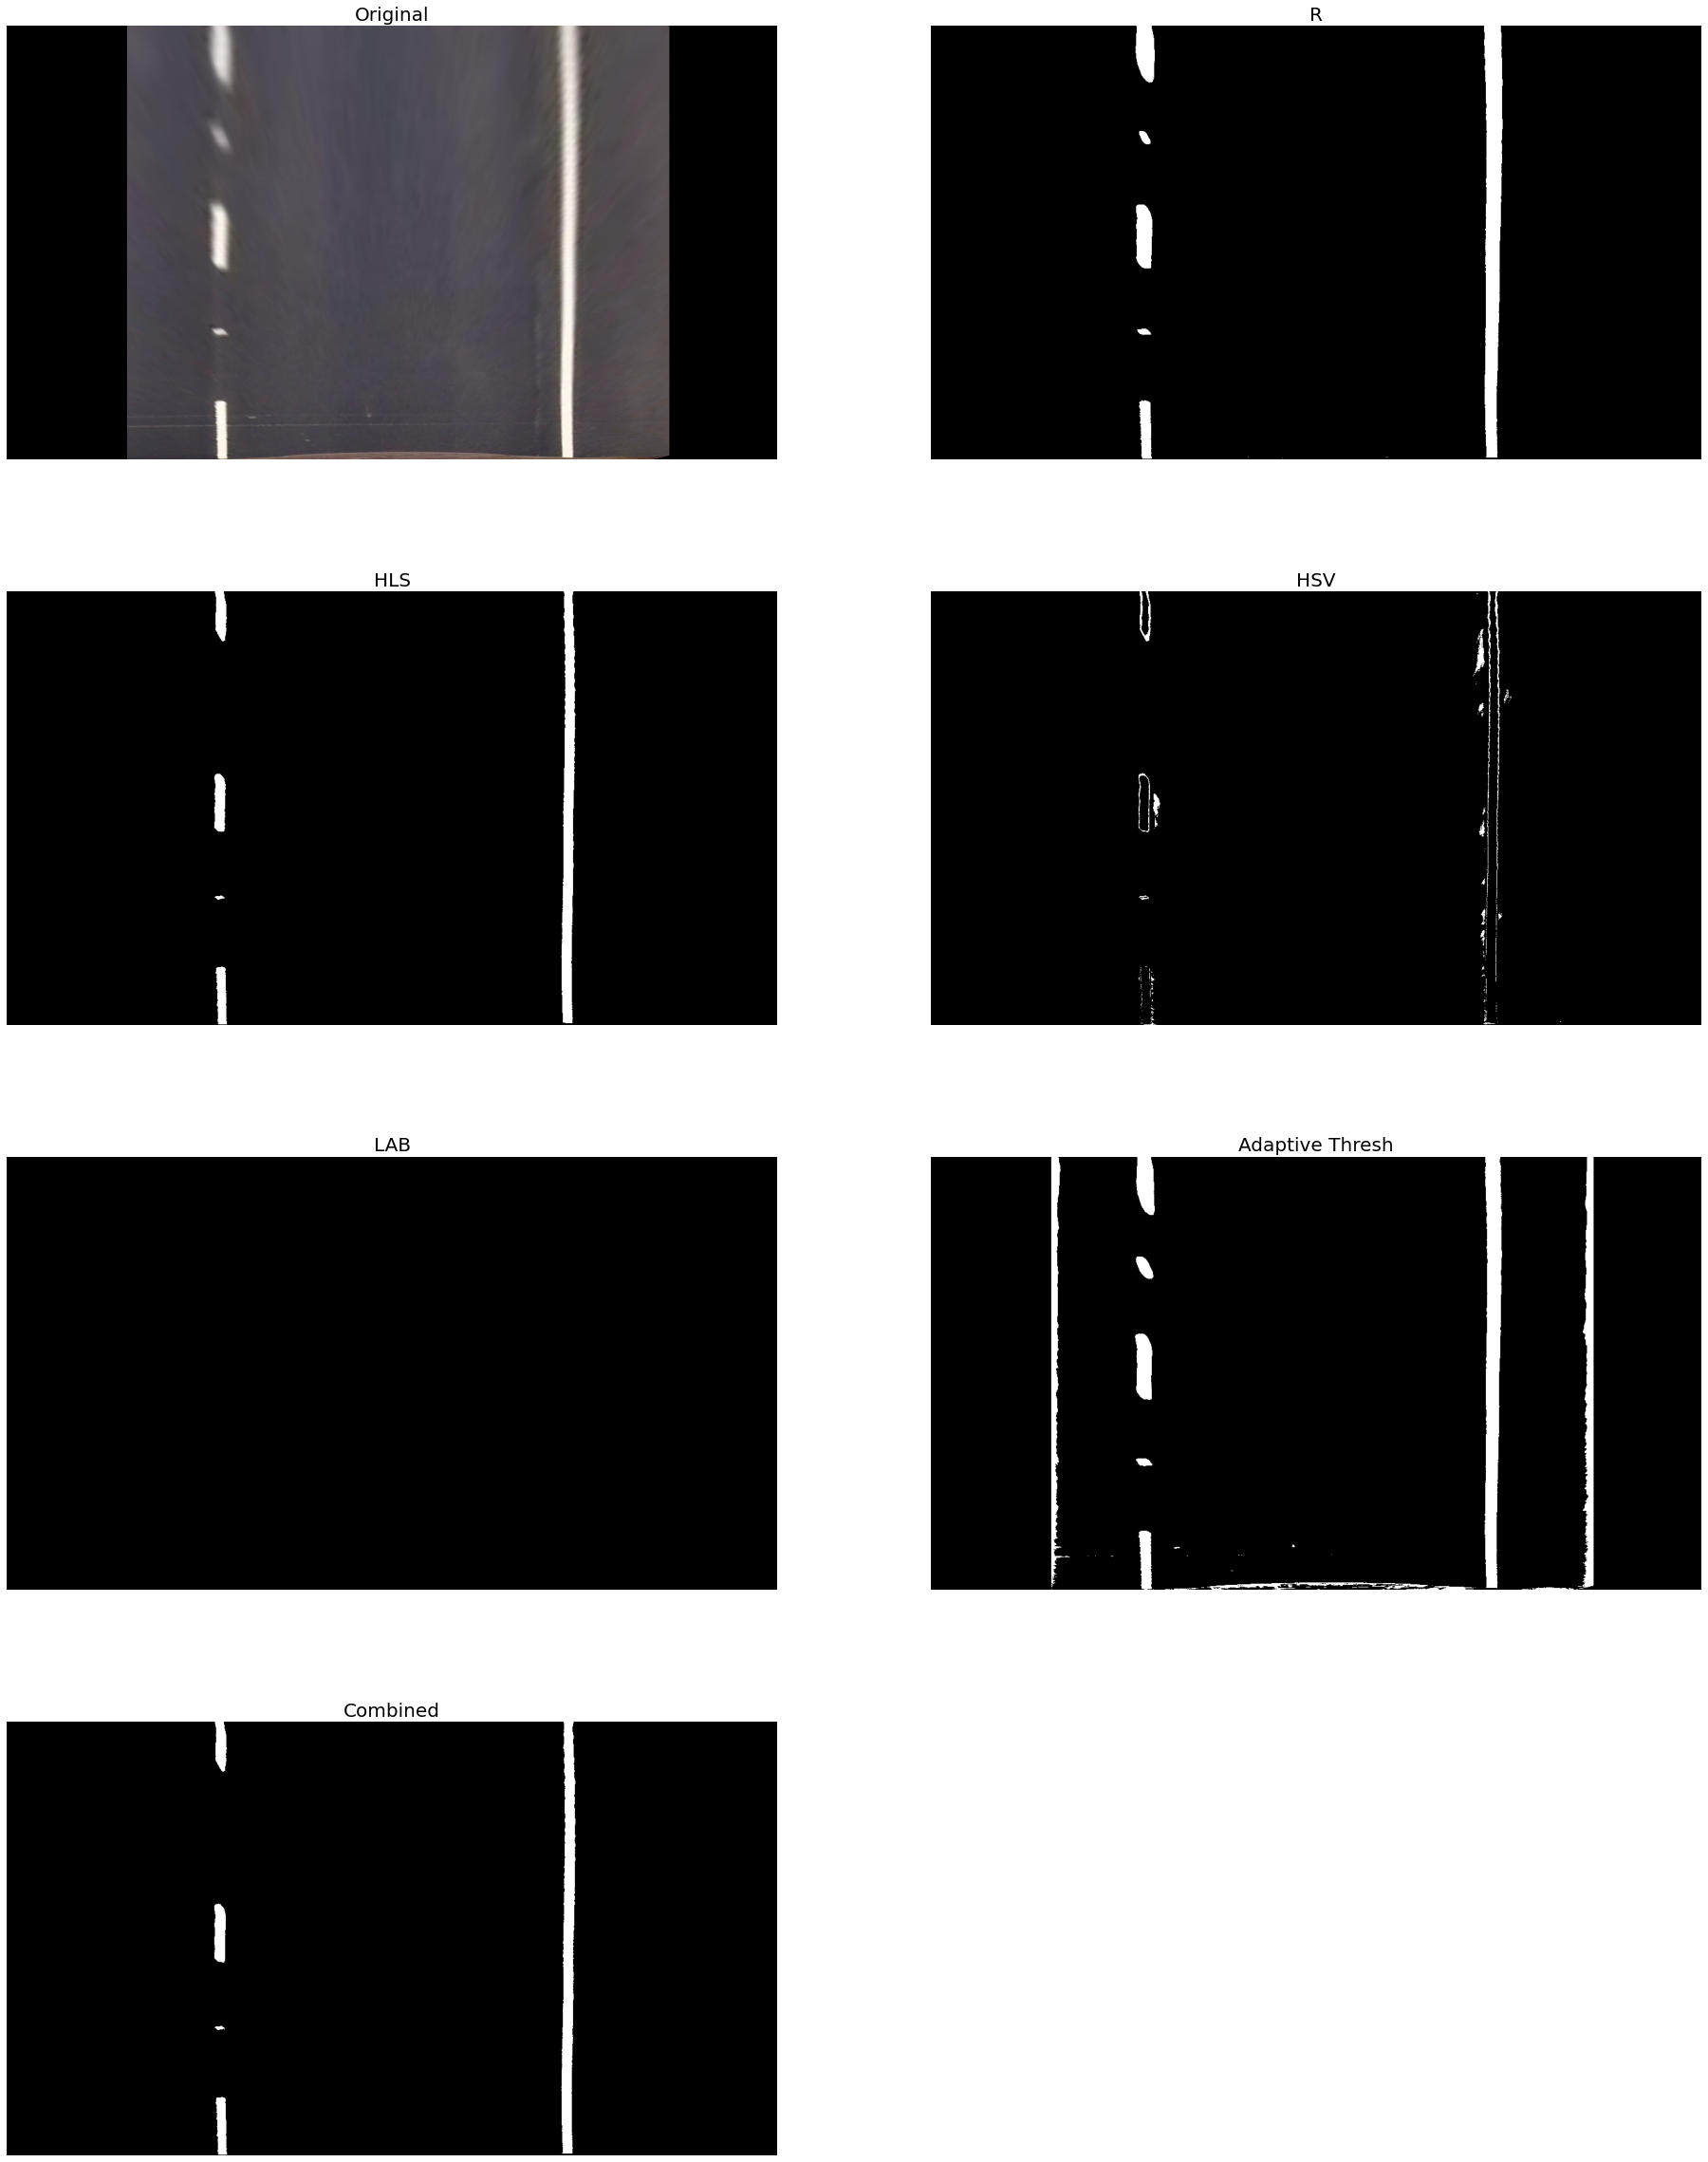

In [8]:
if 3 in plot_demo:
    for img_path in test_img_paths[:2]: #video2[5:10]:
        img, _ = get_image(img_path)
        get_binary_image(img, visualise=True)

## 4. Detect Lane Lines: Peaks in Histogram & Sliding Window Technique

In [11]:
def get_poly_points(left_fit, right_fit):
    '''
    Get the points for the left lane/ right lane defined by the polynomial coeff's 'left_fit'
    and 'right_fit'
    :param left_fit (ndarray): Coefficients for the polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the polynomial that defines the right lane line
    : return (Tuple(ndarray, ndarray, ndarray, ndarray)): x-y coordinates for the left and right lane lines
    '''
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(int), plot_yleft.astype(int), plot_xright.astype(int), plot_yright.astype(int)

def check_validity(left_fit, right_fit, diagnostics=False):
    '''
    Determine the validity of lane lines represented by a set of second order polynomial coefficients 
    :param left_fit (ndarray): Coefficients for the 2nd order polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the 2nd order polynomial that defines the right lane line
    :param diagnostics (boolean): Boolean flag for logging
    : return (boolean)
    '''
    
    if left_fit is None or right_fit is None:
        return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.35) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.75)

    # Compute the respective x-values for both lines
    x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
    x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
    x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

    x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
    x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
    x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

    # Compute the L1 norms
    x1_diff = abs(x1l - x1r)
    x2_diff = abs(x2l - x2r)
    x3_diff = abs(x3l - x3r)

    # Define the threshold values for each of the three points
    min_dist_y1 = 480 # 510 # 530 
    max_dist_y1 = 730 # 750 # 660
    min_dist_y2 = 280
    max_dist_y2 = 730 # 660
    min_dist_y3 = 140
    max_dist_y3 = 730 # 660
    
    if (x1_diff < min_dist_y1) | (x1_diff > max_dist_y1) | \
        (x2_diff < min_dist_y2) | (x2_diff > max_dist_y2) | \
        (x3_diff < min_dist_y3) | (x3_diff > max_dist_y3):
        if diagnostics:
            print("Violated distance criterion: " +
                  "x1_diff == {:.2f}, x2_diff == {:.2f}, x3_diff == {:.2f}".format(x1_diff, x2_diff, x3_diff))
        return False

    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 0.6 #0.58 
    if (norm1 >= thresh) | (norm2 >= thresh):
        if diagnostics:
            print("Violated tangent criterion: " +
                  "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
            return False
    
    return True

def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    '''
    Detect lane lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param lane_width_px (int): Average lane line width (in px) for the warped image 
    computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    
    global cache
    ret = True

    # Sanity check
    if binary.max() <= 0:
        return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        if histogram.max() > 0:
            break

    if histogram.max() == 0:
        print('Unable to detect lane lines in this frame. Trying another frame!')
        return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_images([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255

    nb_windows = 12 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 50 # min number of pixels needed to recenter the window
    window_height = int(IMG_SHAPE[0] / nb_windows)
    min_lane_pts = 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
   
    if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
        if len(cache) == 0:
            if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
            return False, np.array([]), np.array([])
        
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    if visualise:
        plot_images([(img, 'Original'), (out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

### 4.1 Demo

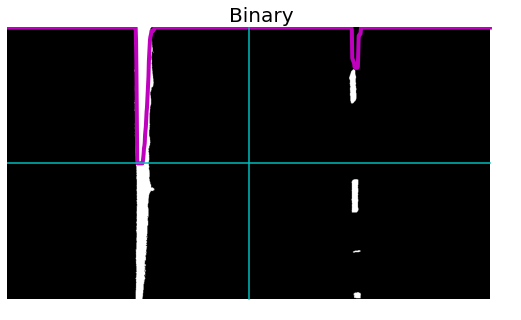

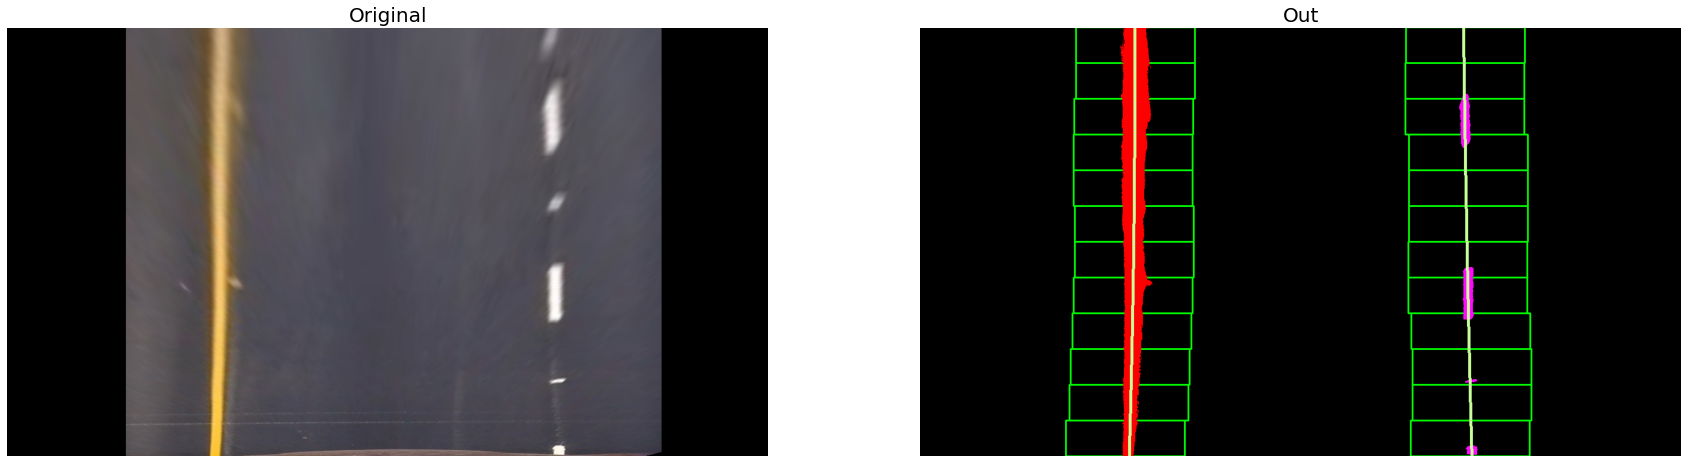

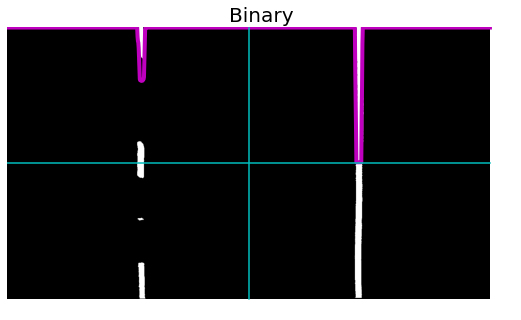

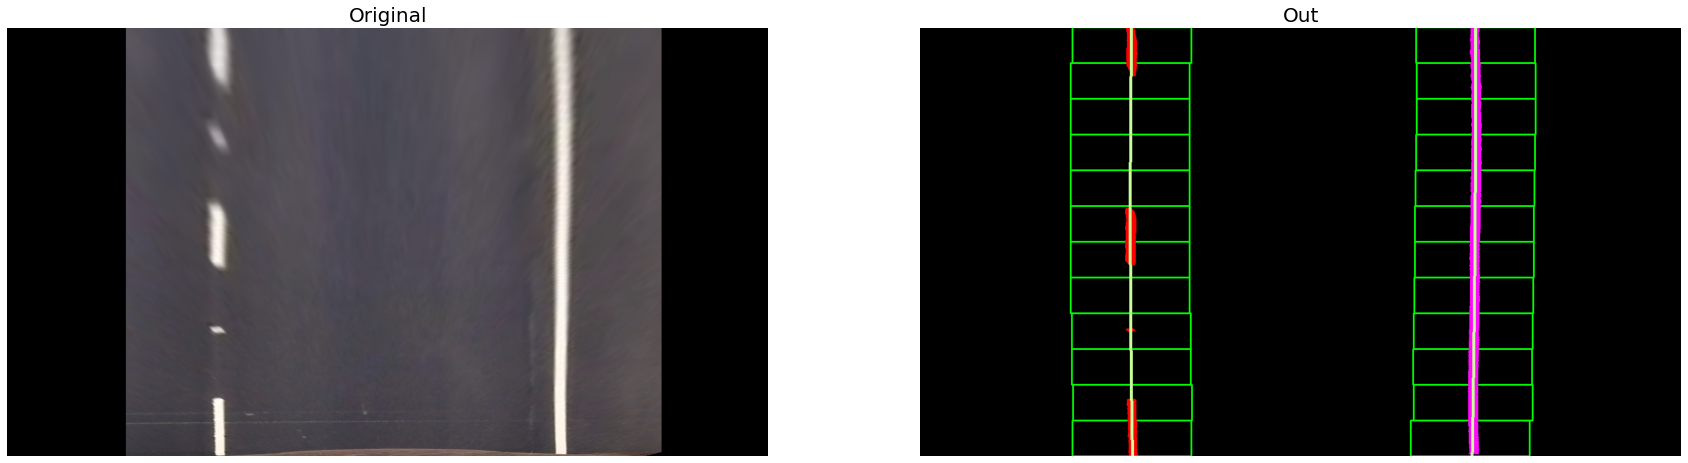

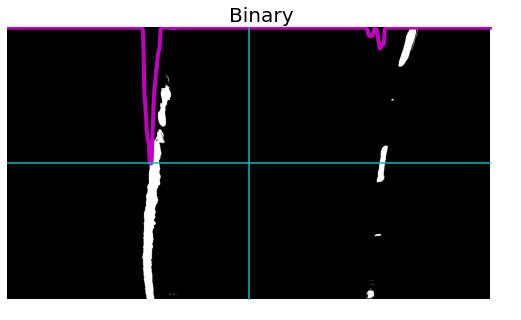

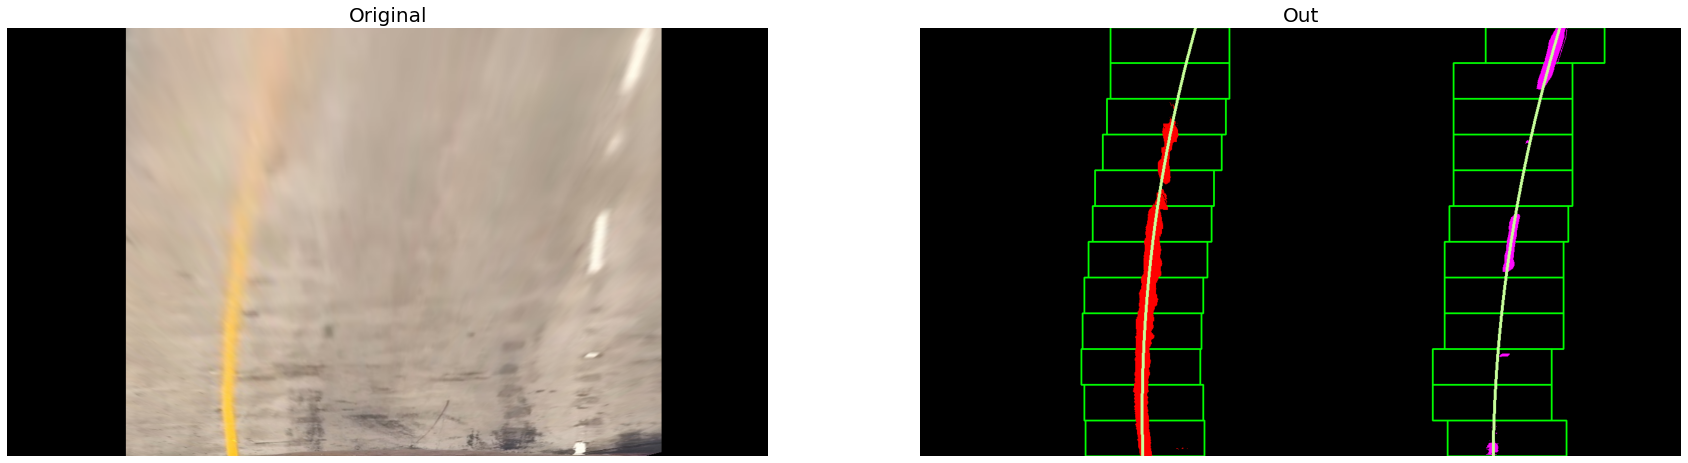

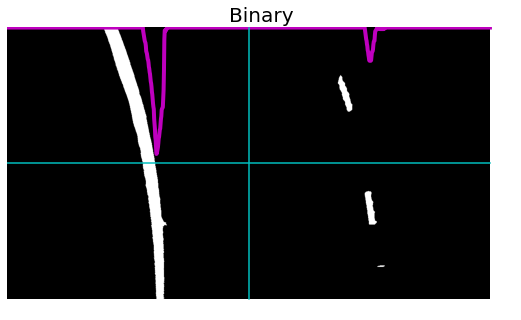

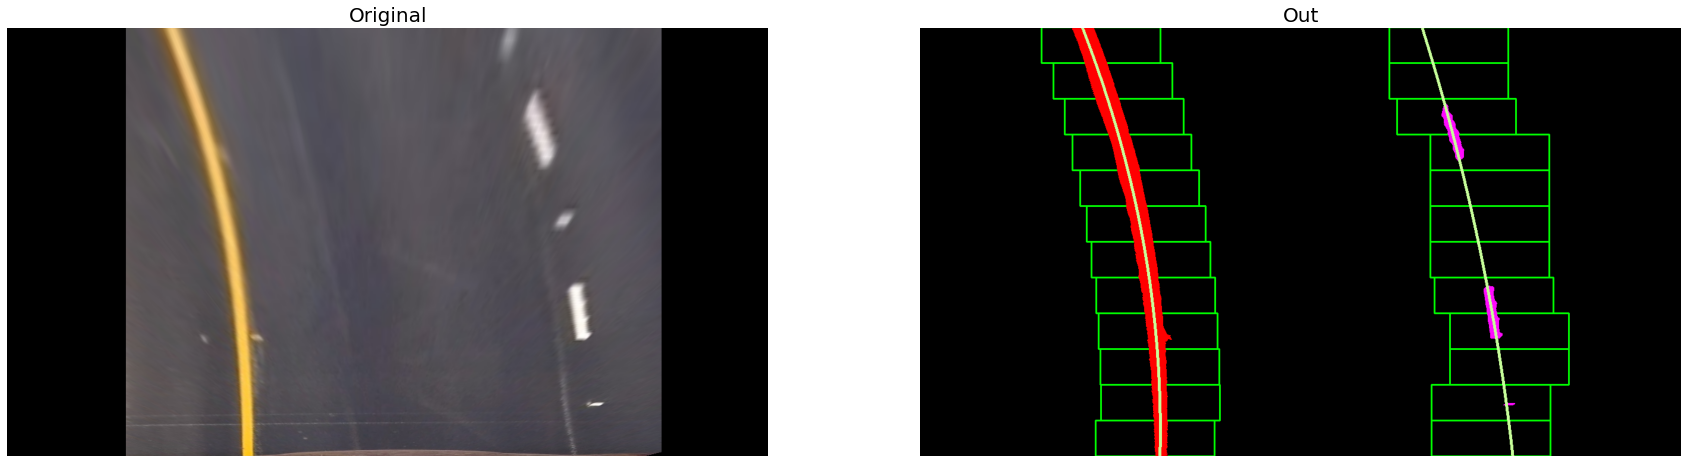

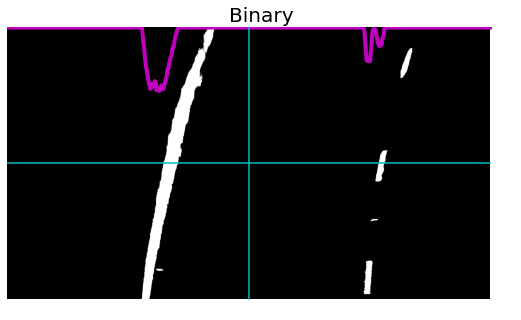

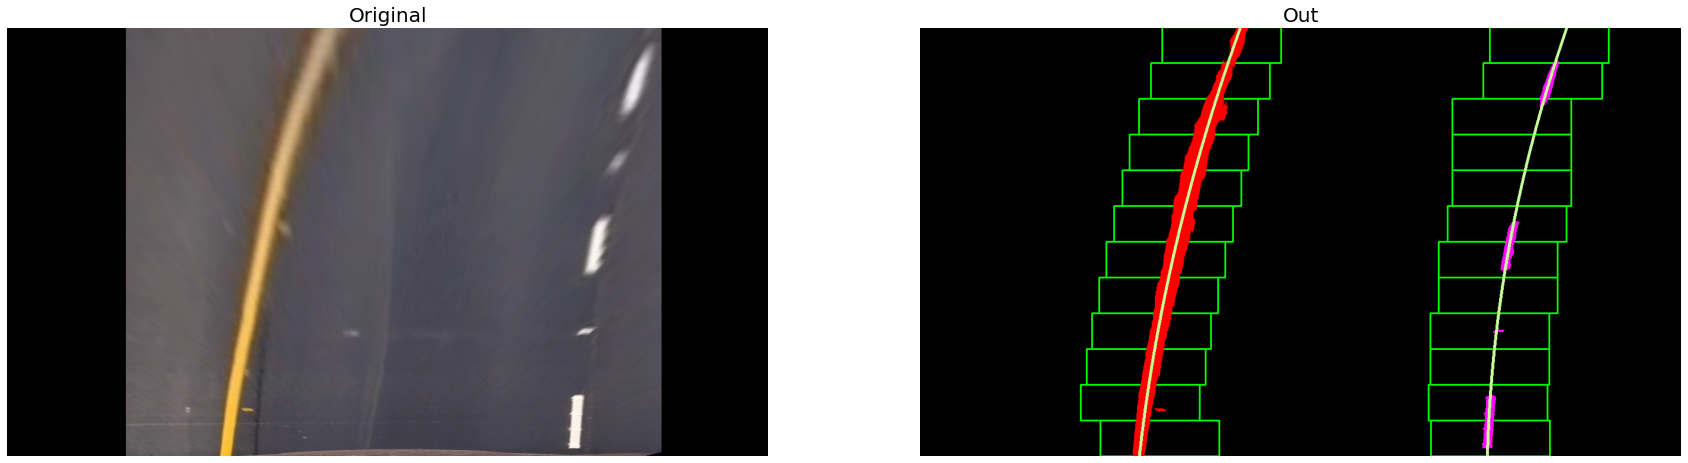

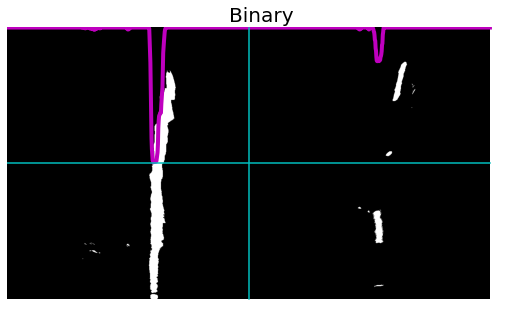

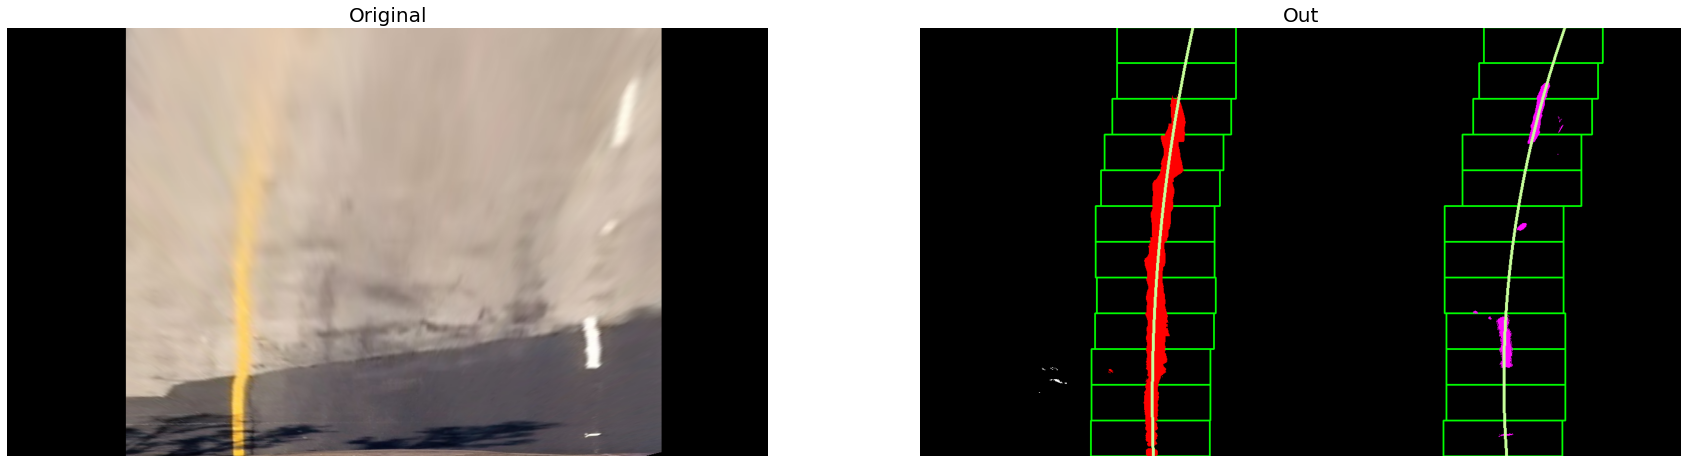

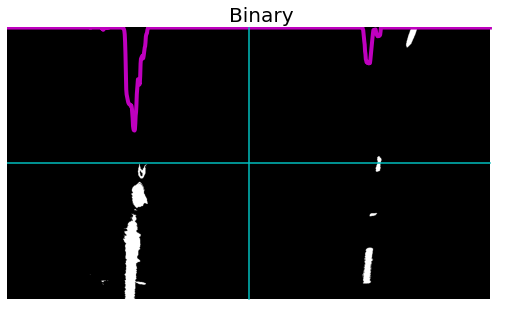

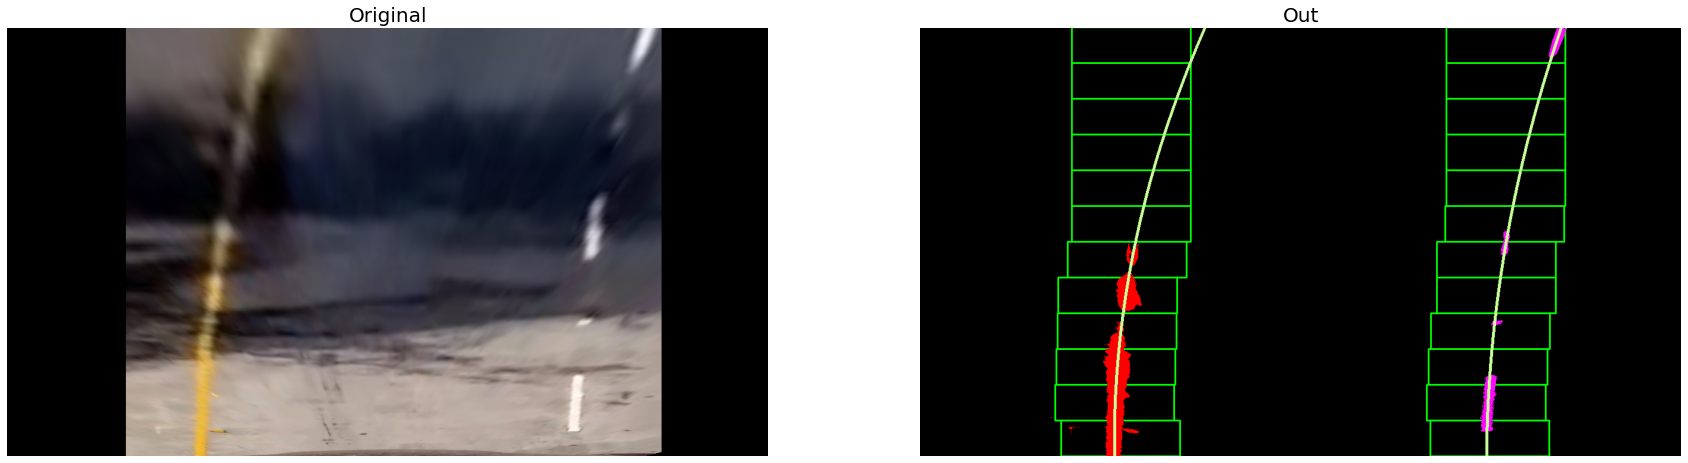

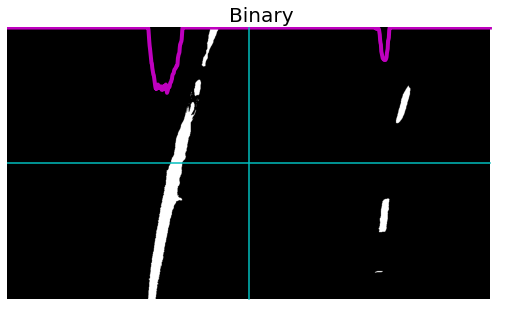

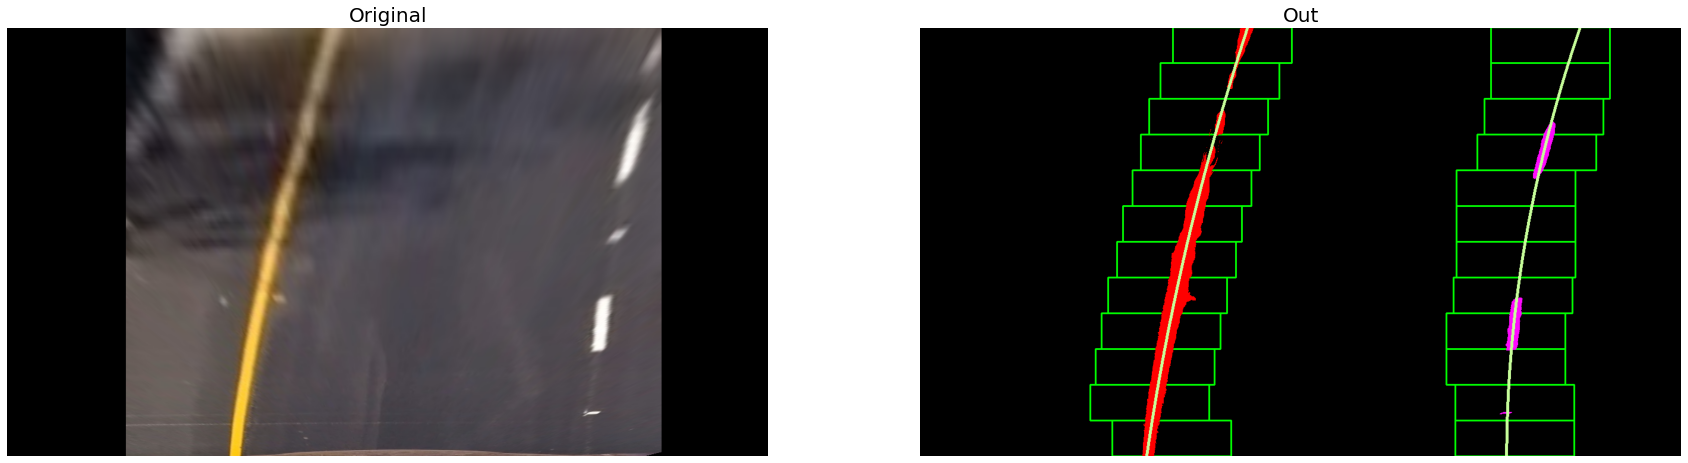

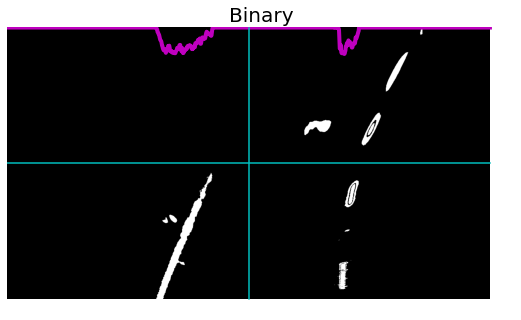

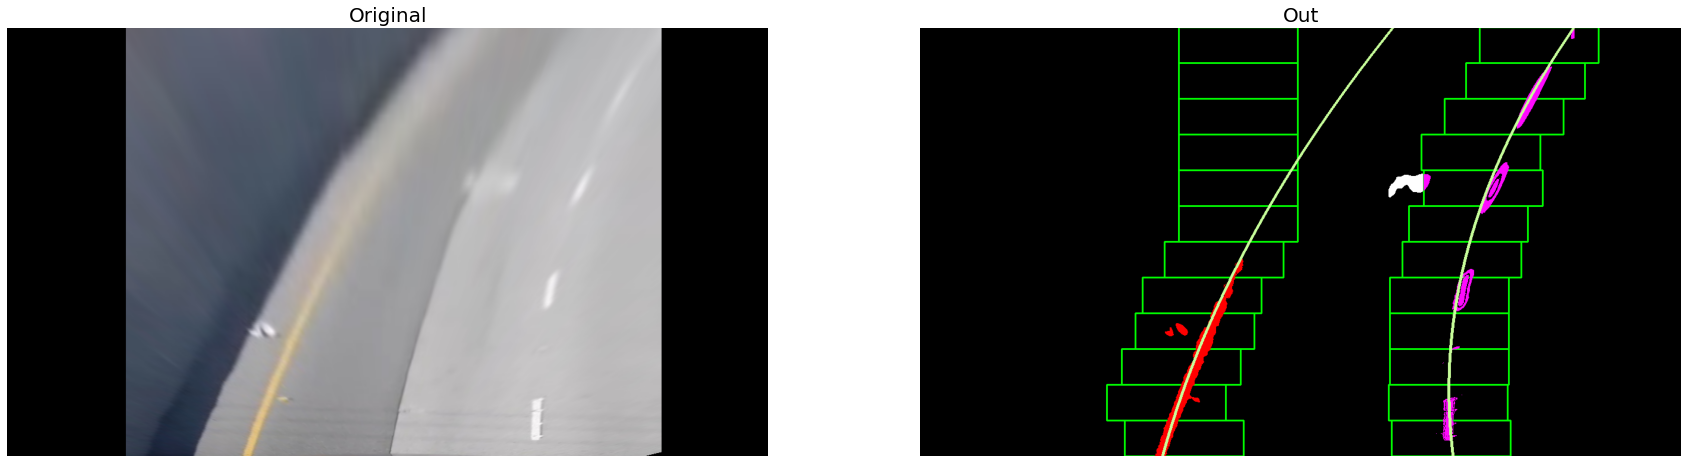

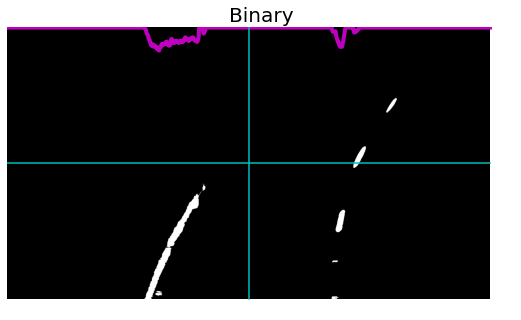

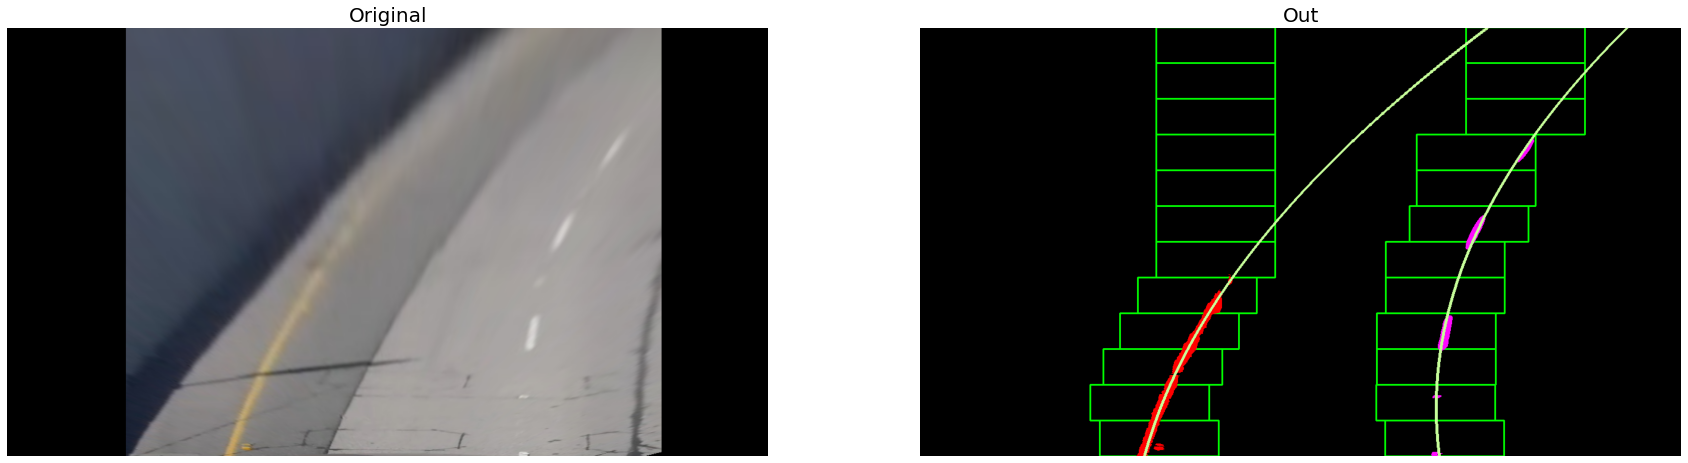

In [12]:
if 4 in plot_demo:

    cache = np.array([])

    for img_path in test_img_paths[:]: #video2[134:138]:
        img, _ = get_image(img_path)
        binary = get_binary_image(img, visualise=False)
        polyfit_sliding_window(binary, visualise=True)

## 5. Detect Lane Lines: Adaptive Search 

In [13]:
def polyfit_adapt_search(img, prev_poly_param, visualise=False, diagnostics=False):
    '''
    Function that: 
    1. Uses the sliding window technique to perform incremental localised adaptive threhsolding
    over the previosuly detected lane line trajectory to develop a threhsolded binary image. Then,
    2. Uses this generated binary image to detect and fit lane lines in a margin around the previous fit rather 
    than performing a blind search
    :param img (ndarray): Warped image
    :param prev_poly_param (ndarray): Polynomial coefficients of the previously detected lane lines
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnostics (boolean): Boolean flag for logging
    : return (ndarray, ndarray): 3 channel image with the newly detected lane lines, current polynomial coefficients
    '''
    
    global cache # Cache of the previosuly detected lane line coefficients
    global attempts # Number of retries before the pipeline is RESET to detect lines via the smoothing window aproach
    
    # Sanity check
    assert(len(img.shape) == 3)
    
    # Setup
    nb_windows = 10 # Number of windows over which to perform the localised color thresholding  
    bin_margin = 80 # Width of the windows +/- margin for localised thresholding
    margin = 60 # Width around previous line positions +/- margin around which to search for the new lines
    window_height = int(img.shape[0] / nb_windows)
    smoothing_window = 5 # Number of frames over which to compute the Moving Average
    min_lane_pts = 10
    
    binary = np.zeros_like(img[:,:,0]) # Placeholder for the thresholded binary image
    img_plot = np.copy(img)
        
    left_fit, right_fit = prev_poly_param[0], prev_poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    leftx_current = np.int(plot_xleft[-1])
    rightx_current = np.int(plot_xright[-1])
    
    # Iterate over the windows, perform localised color thresholding and generate the binary image
    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (window + 1) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height
        win_xleft_low = min(max(0, leftx_current - bin_margin), 1280)
        win_xleft_high = min(max(0, leftx_current + bin_margin), 1280)
        win_xright_low = min(max(0, rightx_current - bin_margin), 1280)
        win_xright_high = min(max(0, rightx_current + bin_margin), 1280)

        img_win_left = img[win_y_low:win_y_high, win_xleft_low:win_xleft_high,:]
        binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = \
            get_binary_image(img_win_left, visualise=False)

        img_win_right = img[win_y_low:win_y_high, win_xright_low:win_xright_high, :]
        binary[win_y_low:win_y_high, win_xright_low:win_xright_high] = \
            get_binary_image(img_win_right, visualise=False)

        # Given that we only keep the points/values for a line that lie within the image
        # (see 'get_poly_points'), the overall length and consequently number of points (i.e. x-values
        # and y-values) can be < the length of the image. As a result, we check for the presence
        # of the current window's lower y-value i.e 'win_y_low' as a valid point within the previously detected line
        # If, a point associated with this y-value exists, we update the x-position of the next window with
        # the corresponding x-value.
        # Else, we keep the x-position of the subsequent windows the same and move up the image
        idxs = np.where(plot_yleft == win_y_low)[0]
        if len(idxs) != 0:
            leftx_current = int(plot_xleft[idxs[0]])
            
        idxs = np.where(plot_yright == win_y_low)[0]
        if len(idxs) != 0:
            rightx_current = int(plot_xright[idxs[0]])

        if visualise:
            left_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
            right_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])
            
            # Plot the previously detected lane lines
            cv2.polylines(img_plot, np.int32([left_pts]), isClosed=False, color=(255, 20, 147), thickness=4)
            cv2.polylines(img_plot, np.int32([right_pts]), isClosed=False, color=(255, 20, 147), thickness=4)    
            
            bin_win_left = binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high]
            bin_win_left = np.dstack((bin_win_left, np.zeros_like(bin_win_left), np.zeros_like(bin_win_left))) * 255

            bin_win_right = binary[win_y_low:win_y_high, win_xright_low:win_xright_high]
            bin_win_right = np.dstack([np.zeros_like(bin_win_right), np.zeros_like(bin_win_right), bin_win_right]) * 255
            
            # Blend the localised image window with its corresponding thresholded binary version
            win_left = cv2.addWeighted(bin_win_left, 0.5, img_win_left, 0.7, 0)
            win_right = cv2.addWeighted(bin_win_right, 0.5, img_win_right, 0.7, 0)
            
            # Draw the binary search window
            cv2.rectangle(img_plot, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 5)
            cv2.rectangle(img_plot, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 5)
            
            f, _ = plt.subplots(1, 2, figsize=(13,5))

            plt.subplot(121)
            plt.axis('off')
            plt.imshow(binary, cmap='gray')

            plt.subplot(122)
            plt.axis('off')
            plt.imshow(img_plot)

            plt.subplots_adjust(top=0.98, bottom=0.0, left=0.0, right=1.0, hspace=0.1, wspace=0.05)
            plt.savefig('./gif_images/window1{:02}.png'.format(window))
            
            # The blended Binary window and Image window is added later for better visualisation
            img_plot[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = win_left
            img_plot[win_y_low:win_y_high, win_xright_low:win_xright_high] = win_right
        
    # Identify the x-y coordinates of all the non-zero pixels from the binary image
    # generated above
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract all the 
    left_lane_inds = \
        ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = \
        ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Sanity checks
    if len(leftx) > min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the left lane. {}'.format(min_lane_pts, len(leftx)))

    if len(rightx) > min_lane_pts:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the right lane. {}'.format(min_lane_pts, len(rightx)))
        
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)

    # Perform smoothing via moving average
    if valid:
        if len(cache) < smoothing_window:
            cache = np.concatenate((cache, [np.array([left_fit, right_fit])]), axis=0)
        elif len(cache) >= smoothing_window:
            cache[:-1] = cache[1:]
            cache[-1] = np.array([left_fit, right_fit])
  
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
        curr_poly_param = np.array([left_fit, right_fit])
    else:
        attempts += 1
        curr_poly_param = prev_poly_param
    
    out = np.dstack([binary, binary, binary]) * 255
    win_img = np.zeros_like(out)

    # Color the lane line pixels
    out[lefty, leftx] = [255, 0, 0]
    out[righty, rightx] = [255, 10, 255]

    left_window1 = np.array([np.transpose(np.vstack([plot_xleft - margin, plot_yleft]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xleft + margin, plot_yleft])))])
    left_pts = np.hstack([left_window1, left_window2])

    right_window1 = np.array([np.transpose(np.vstack([plot_xright - margin, plot_yright]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xright + margin, plot_yright])))])
    right_pts = np.hstack([right_window1, right_window2])

    # Draw the search boundary
    cv2.fillPoly(win_img, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(win_img, np.int_([right_pts]), (0, 255, 0))

    out = cv2.addWeighted(out, 1, win_img, 0.25, 0)

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Draw the fit lane lines
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    return out, curr_poly_param

### 5.1 Demo

In [14]:
if 5 in plot_demo:
    cache = np.array([])
    attempts = 0
    max_attempts = 4
    reset = True
    
    for frame_path in video2[0: 5]:
        img = mpimg.imread(frame_path)
        warped, (M, invM) = get_image(frame_path)
        
        if reset == True:
            binary = get_binary_image(warped)
            ret, out, poly_param = polyfit_sliding_window(binary, visualise=False, diagnostics=True)
            if ret:
                reset = False
                cache = np.array([poly_param])
                
        else:
            out, poly_param = polyfit_adapt_search(warped, poly_param, visualise=False, diagnostics=False)
            if attempts == max_attempts:
                attempts = 0
                reset = True
        
            out_unwarped = cv2.warpPerspective(out, invM, (IMG_SHAPE[1], IMG_SHAPE[0]), flags=cv2.INTER_LINEAR)

            img_overlay = np.copy(img)
            img_overlay = cv2.addWeighted(out_unwarped, 0.5, img, 0.5, 0)
            
            plot_images([(warped, 'Original'), (out, 'Out'), (img_overlay, 'Overlay')], figsize=(20, 18))

## 6. Compute meters/pixel

In [15]:
def compute_mppx(img, dashed_line_loc, visualise=False):
    '''
    Converts from pixel space to real world space and calculates the metres/pixel
    :param img (ndarray): Warped Image
    :param dashed_line_loc (string): Dashed line location (left/right)
    :param visualise (boolean): Boolean flag for visualisation
    : return (float32, float32): (metres/pixel y direction, metres/pixel x-direction)
    '''
    lane_width = 3.7
    dashed_line_len = 3.048
    
    if dashed_line_loc == 'left':
        y_top = 295
        y_bottom = 405
    elif dashed_line_loc == 'right':
        y_top = 395
        y_bottom = 495
        
    binary = get_binary_image(img)
    histogram = np.sum(binary[int(binary.shape[0] / 2):, :], axis=0)
    midpoint = int(histogram.shape[0] / 2)
    
    x_left = np.argmax(histogram[:midpoint])
    x_right = np.argmax(histogram[midpoint:]) + midpoint
    
    x_mppx = lane_width / (x_right - x_left)
    y_mppx = dashed_line_len / (y_bottom - y_top)
    
    if visualise:
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        
        if dashed_line_loc == 'left':
            plt.plot((x_left, x_left), (y_top, y_bottom), 'r')
            plt.text(x_left + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r', fontsize=20)

        elif dashed_line_loc == 'right':
            plt.plot((x_right, x_right), (y_top, y_bottom), 'r')
            plt.text(x_right + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r',fontsize=20)

        plt.plot((x_left, x_right), (img.shape[0] - 200 , img.shape[0] - 200), 'r')
        plt.text((x_left + x_right) // 2, img.shape[0] - 220, '{} m'.format(lane_width), color='r', fontsize=20)
        
    return y_mppx, x_mppx

### 6.1 Demo

Average meter/px along x-axis: 0.0064
Average meter/px along y-axis: 0.0291


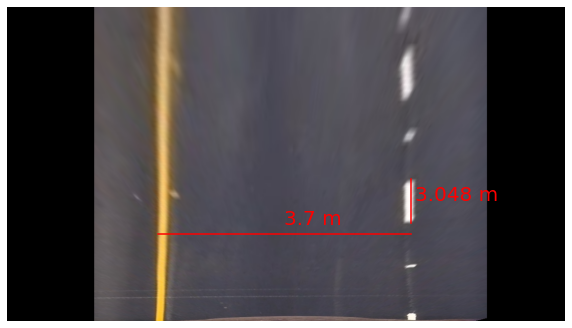

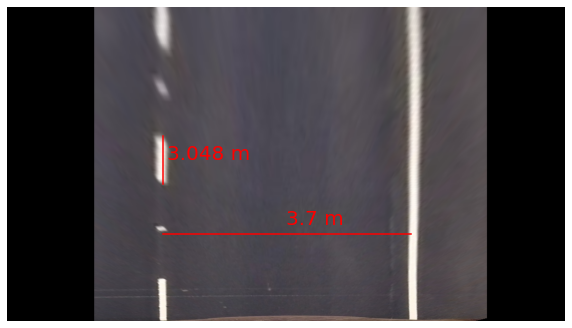

In [16]:
if 6 in plot_demo:
    visualise = True
else:
    visualise = False

img, _ = get_image(test_img_paths[0])
y_mppx1, x_mppx1 = compute_mppx(img, dashed_line_loc='right', visualise=visualise)

img, _ = get_image(test_img_paths[1])
y_mppx2, x_mppx2 = compute_mppx(img, dashed_line_loc='left', visualise=visualise)

x_mppx = (x_mppx1 + x_mppx2) / 2
y_mppx = (y_mppx1 + y_mppx2) / 2

print('Average meter/px along x-axis: {:.4f}'.format(x_mppx))
print('Average meter/px along y-axis: {:.4f}'.format(y_mppx))

## 7. Compute Lane Line Curvature

In [17]:
def compute_offset_from_center(poly_param, x_mppx):
    '''
    Computes the offset of the car from the center of the detected lane lines
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param x_mppx (float32): metres/pixel in the x-direction
    :return (float32): Offset 
    '''
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(poly_param[0], poly_param[1])
    
    lane_center = (plot_xright[-1] + plot_xleft[-1]) / 2
    car_center = IMG_SHAPE[1] / 2
    
    offset = (lane_center - car_center) * x_mppx
    return offset

def compute_curvature(poly_param, y_mppx, x_mppx):
    '''
    Computes the curvature of the lane lines (in metres)
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param y_mppx (float32): metres/pixel in the y-direction
    :param x_mppx (float32): metres/pixel in the x-direction
    :return (float32): Curvature (in metres) 
    '''
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(poly_param[0], poly_param[1])
    
    y_eval = np.max(plot_yleft)

    left_fit_cr = np.polyfit(plot_yleft * y_mppx, plot_xleft * x_mppx, 2)
    right_fit_cr = np.polyfit(plot_yright * y_mppx, plot_xright * x_mppx, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]* y_eval*y_mppx + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*y_mppx + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def draw(img, warped, invM, poly_param, curve_rad, offset):
    '''
    Utility function to draw the lane boundaries and numerical estimation of lane curvature and vehicle position.
    :param img (ndarray): Original image
    :param warped (ndarray): Warped image
    :param invM (ndarray): Inverse Perpsective Transformation matrix
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param curve_rad (float32): Lane line curvature
    :param offset (float32): Car offset
    :return (ndarray): Image with visual display
    '''
    
    undist = undistort(img, mtx, dist)
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = poly_param[0]
    right_fit = poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([plot_xright, plot_yright])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Color the road
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 220, 110))
                    
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False,
                  color=(255, 255, 255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False,
                  color=(255, 255, 255), thickness= 10)
    
    # Unwarp and merge with undistorted original image
    unwarped = cv2.warpPerspective(color_warp, invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    out = cv2.addWeighted(undist, 1, unwarped, 0.4, 0)
    
    # Write data on the image
    if (left_fit[1] + right_fit[1]) / 2 > 0.05:
        text = 'Left turn, curve radius: {:04.2f} m'.format(curve_rad)
    elif (left_fit[1] + right_fit[1]) / 2 < -0.05:
        text = 'Right turn, curve radius: {:04.2f} m'.format(curve_rad)
    else:
        text = 'Straight'
    
    cv2.putText(out, text, (50, 60), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    
    direction = ''
    if offset > 0:
        direction = 'left'
    elif offset < 0:
        direction = 'right'
    
    text = '{:0.1f} cm {} of center'.format(abs(offset) * 100, direction)
    cv2.putText(out, text, (50, 110), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    
    return out

### 7.1 Demo

In [19]:
### DEMO
if 7 in plot_demo:
    cache = np.array([])
    
    for img_path in video1[1000: 1010]:#test_img_paths:
        img = mpimg.imread(img_path)
        warped, (M, invM) = get_image(img_path)
        
        binary = get_binary_image(warped)
        ret, img_poly, poly_param = polyfit_sliding_window(binary)
        
        left_curverad, right_curverad = compute_curvature(poly_param, y_mppx, x_mppx)
        curvature = (left_curverad + right_curverad) / 2
        offset = compute_offset_from_center(poly_param, x_mppx)
        result = draw(img, warped, invM, poly_param, curvature, offset)
        
        plot_images([(img_poly, 'Polyfit'), (result, 'Result')])

## 8. Pipeline

In [20]:
def triple_split_view(images):
    '''
    Utility function to create triple split view for display in video
    :param images ([ndarray]): List of images
    :returm (ndarray): Single RGB image 
    '''

    scale_factor = 2
    
    # Sizes/shapes are in (x,y) format for convenience use with cv2
    img_shape = IMG_SHAPE[::-1]
    scaled_size = (round(img_shape[0] / scale_factor), round(img_shape[1] / scale_factor))
    x_max, y_max = img_shape[0], img_shape[1] + scaled_size[1] # x, y + y'

    # Top-left corner positions for each of the three windows
    positions = [(0,0), (0, img_shape[1]), (round(0.5 * img_shape[0]), img_shape[1])]
    sizes = [img_shape, scaled_size, scaled_size] 
    
    out = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for idx, img in enumerate(images):
        # Resize the image
        if img.shape[0] != sizes[idx][1] | img.shape[1] != sizes[idx][0]:
            img = cv2.resize(img, dsize=sizes[idx])

        # Place the resized image onto the final output image
        x, y = positions[idx]
        w, h = sizes[idx]
        out[y:min(y + h, y_max), x:min(x + w, x_max), :] = img[:min(h, y_max - y), :min(w, x_max - x)]

    return out

def pipeline(img, visualise=False, diagnostics=False):
    global cache
    global poly_param # Important for successive calls to the pipeline
    global attempts
    global reset
    max_attempts = 5
    
    result = np.copy(img)
    warped, (M, invM) = preprocess_image(img)
    title = ''
   
    try:
        if reset == True:
            title = 'Sliding window'
            if diagnostics: print(title)
            
            binary = get_binary_image(warped)
            ret, img_poly, poly_param = polyfit_sliding_window(binary, diagnostics=diagnostics)
            if ret:
                if diagnostics: print('Success!')
                reset = False
                cache = np.array([poly_param])
            else:
                if len(img_poly) == 0:
                    print('Sliding window failed!')
                    return img
                
        else:
            title = 'Adaptive Search'
            if diagnostics: print(title)
            
            img_poly, poly_param = polyfit_adapt_search(warped, poly_param, diagnostics=diagnostics)
            if attempts == max_attempts:
                if diagnostics: print('Resetting...')
                reset = True
                attempts = 0
        
        left_curverad, right_curverad = compute_curvature(poly_param, y_mppx, x_mppx)
        offset = compute_offset_from_center(poly_param, x_mppx)
        result = draw(img, warped, invM, poly_param, (left_curverad + right_curverad) / 2, offset)

        blended_warped_poly = cv2.addWeighted(img_poly, 0.6, warped, 1, 0)
        ret2 = np.hstack([img_poly, blended_warped_poly])
        ret3 = np.hstack([result, warped])
#         ret3 = triple_split_view([result, img_poly, blended_warped_poly])
        ret3 = np.vstack([ret3, ret2])
        if visualise:
            plt.figure(figsize=(20, 12))
            plt.title(title)
            plt.imshow(ret3)

        return ret3
    
    except Exception as e:
        print(e)
        return img

### 8.1 Demo

In [21]:
if 8 in plot_demo:
    print('Demo of consecutive frames')
    
    cache = np.array([])
    attempts = 0
    reset = True
    
    for img_path in video2[0:15]:
        img = mpimg.imread(img_path)
        result = pipeline(img, visualise=True, diagnostics=1)

Demo of consecutive frames


## 9. Process Video

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_frame = lambda frame: pipeline(frame, diagnostics=1)

# Pipeline initialisation
cache = np.array([])
attempts = 0
reset = True

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(18,27)                          
processed_video = video_input.fl_image(process_frame)
%time processed_video.write_videofile(video_output, audio=False)

# video1_output = 'challenge_video_output.mp4'
# video1_input = VideoFileClip('challenge_video.mp4')#.subclip(4, 7)                          
# processed_video = video1_input.fl_image(process_frame)
# %time processed_video.write_videofile(video1_output, audio=False)

# video2_output = 'harder_challenge_video_output.mp4'
# video2_input = VideoFileClip('harder_challenge_video.mp4')                          
# processed_video = video2_input.fl_image(process_frame)#.subclip(0,5)
# %time processed_video.write_videofile(video2_output, audio=False)

Sliding window
Success!
Moviepy - Building video project_video_output.mp4.
MoviePy - Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video project_video_output.mp4



TypeError: must be real number, not NoneType